In [27]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite

import minorminer
#import dwave.inspector

from src.particle_funcs import distance_matrix as distance_matrix
import src.leap_funcs.qubo.q_matrix as q_matrix

[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1.]


C:\Users\oahre\AppData\Local\Temp\ipykernel_20984\4123327838.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_initial.show()


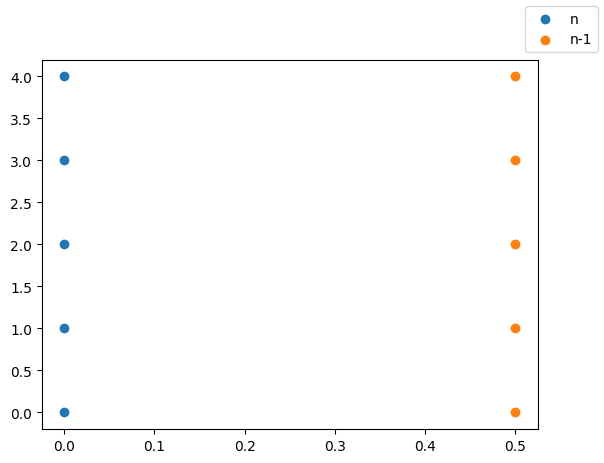

In [2]:
num_particles = 5

use_dimod_exact_solver = False

part_coords_n = np.zeros((num_particles,2))
part_coords_nm1 = np.zeros((num_particles,2))

for i in range(np.shape(part_coords_n)[0]):
    part_coords_n[i,:] = [0, i]
    part_coords_nm1[i,:] = [0.5*1, i]

fig_initial, axs_initial = plt.subplots(1,1)
axs_initial.scatter(part_coords_n[:,0], part_coords_n[:,1], label="n")
axs_initial.scatter(part_coords_nm1[:,0], part_coords_nm1[:,1], label="n-1")
fig_initial.legend()
fig_initial.show()

correct_sol = np.zeros(num_particles*num_particles)
for i in range(1, num_particles+1):
    correct_sol[(i-1)*num_particles + i -1] = 1.

print(correct_sol)

In [3]:
distances = distance_matrix.calc_phi_ij(part_coords_n, part_coords_nm1)
#print(distances)

In [4]:
Q_dist = q_matrix.q_dist(distances)
#assert (Q_dist.transpose() == Q_dist).all(), 'Q_dist is not symmetric'
#with np.printoptions(precision=3):
#    print(Q_dist)

Q_dist_diag = q_matrix.q_dist_diag(distances)
assert (Q_dist_diag.transpose() == Q_dist_diag).all(), 'Q_dist is not symmetric'
#with np.printoptions(precision=3):
#    print(Q_dist_diag)

In [5]:
Q_part = q_matrix.q_part(np.shape(distances)[0])
#print(Q_part)
#assert (Q_part.transpose() == Q_part).all(), 'Q_part is not symmetric'
# changed to only return upper triangular part, so is definitely not symmetric

In [6]:
Q_pos = q_matrix.q_pos(np.shape(distances)[0])
#print(Q_pos)
#assert (Q_pos.transpose() == Q_pos).all(), 'Q_pos is not symmetric'
# changed to only return upper triangular part, so is definitely not symmetric

In [7]:
Q_array = Q_dist_diag + Q_part + Q_pos

#with np.printoptions(precision=3, suppress=True):
#    print(Q_array)

In [8]:
Q_dict = q_matrix.Q_convert_to_dict(Q_array)
#Q_dict = q_matrix.Q_convert_to_dict(Q_array_rem)
#print(Q_dict)

In [9]:
with open('../API_Token.txt') as file:
    token = file.readline().rstrip()
    architecture = file.readline().rstrip()

sampler = DWaveSampler(token = token, architecture='pegasus', region='eu-central-1')
print(DWaveSampler)
print(DWaveSampler._get_solver(sampler))
print(dir(sampler))
print(sampler.properties.keys())
print(sampler.properties['annealing_time_range'])
print(sampler.properties['default_annealing_time'])
print(sampler.properties['programming_thermalization_range'])
print(sampler.properties['default_programming_thermalization'])
print(sampler.properties['readout_thermalization_range'])
print(sampler.properties['default_readout_thermalization'])
print(sampler.properties['per_qubit_coupling_range'])
print(sampler.properties['h_range'])
print(sampler.properties['j_range'])
print(sampler.properties['vfyc'])
print(sampler.__class__)
print(sampler.__slots__)
#print(sampler.__getstate__)
#sampler.__reduce__()
#sampler.properties.values()

<class 'dwave.system.samplers.dwave_sampler.DWaveSampler'>
StructuredSolver(id='Advantage_system5.4')
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_get_solver', '_solver_penalty', 'adjacency', 'client', 'edgelist', 'failover', 'nodelist', 'parameters', 'properties', 'remove_unknown_kwargs', 'retry_interval', 'sample', 'sample_ising', 'sample_qubo', 'solver', 'structure', 'to_networkx_graph', 'trigger_failover', 'valid_bqm_graph', 'validate_anneal_schedule', 'warnings_default']
dict_keys(['num_qubits', 'qubits', 'couplers', 'h_range', 'j_range', 'supported_problem_types', 'parameters', 'vfyc', 'anneal_offset_ranges', 'anneal_of

In [10]:
composite = EmbeddingComposite(sampler)
composite.parameters['annealing_time']

['parameters']

In [11]:
#sampleset= composite.sample_qubo(Q_dict, num_reads=1000, annealing_time=1, return_embedding=True, answer_mode='raw')

In [12]:
composite.child.client.get_solver().estimate_qpu_access_time(num_qubits=5000, num_reads=1000, annealing_time=20, programming_thermalization=1000, readout_thermalization=0)

178923.40251463672

In [13]:
sampler_graph = sampler.to_networkx_graph()
embedding = minorminer.find_embedding(S=Q_dict, T=sampler_graph)

In [14]:
composite_2 = FixedEmbeddingComposite(sampler, embedding)

In [15]:
diagnosis = dwave.embedding.diagnose_embedding(embedding, Q_dict.keys(), sampler_graph)
for item in diagnosis:
    print(item)
print('is_valid_embedding: ', dwave.embedding.is_valid_embedding(embedding, Q_dict.keys(), sampler_graph))

is_valid_embedding:  True


In [16]:
embedding.values()

dict_values([[900, 901], [855, 856, 3259], [3229, 1021, 3260], [930, 931, 3079], [886, 3214], [3125, 3124], [3094, 960], [885, 3019], [3139, 810], [1005, 3065, 3064], [3109, 3110], [2974, 870], [840, 841], [1096, 3095], [3155, 1081], [3004, 1036, 1035], [3170, 3169], [3140, 1020], [975], [3049], [825, 3034, 3033], [990, 3199], [946, 3184], [915, 916], [3154, 871]])

In [17]:
print(len(set(inner for outer in embedding.values() for inner in outer)))
print(len([inner for outer in embedding.values() for inner in outer]))

54
54


In [18]:
num_qubits_comp_2 = len(set(inner for outer in embedding.values() for inner in outer))
num_qubits_comp_2

54

In [19]:
print(composite_2.child.solver.estimate_qpu_access_time(num_qubits=num_qubits_comp_2))
composite_2.parameters['annealing_time'] = 1
print(composite_2.child.solver.estimate_qpu_access_time(num_qubits=num_qubits_comp_2))

14422.953630297587
14422.953630297587


In [20]:
print(sampler.properties['annealing_time_range'])
print(sampler.properties['default_annealing_time'])
print(sampler.properties['programming_thermalization_range'])
print(sampler.properties['default_programming_thermalization'])
print(sampler.properties['readout_thermalization_range'])
print(sampler.properties['default_readout_thermalization'])

params = {'label' : 'superdupernice label',
          'annealing_time': 5, 
          'num_reads': 100, 
          'answer_mode': 'raw', 
          'programming_thermalization': 1000, 
          'readout_thermalization': 100}

[0.5, 2000.0]
20.0
[0.0, 10000.0]
1000.0
[0.0, 10000.0]
0.0


In [21]:
print(composite_2.child.solver.estimate_qpu_access_time(num_qubits=num_qubits_comp_2, **params))

36740.743029758814


In [22]:
sampleset_comp_2 = composite_2.sample_qubo(Q_dict, **params)
sampleset_comp_2.info

{'timing': {'qpu_sampling_time': 20188.0,
  'qpu_anneal_time_per_sample': 5.0,
  'qpu_readout_time_per_sample': 76.34,
  'qpu_access_time': 35068.45,
  'qpu_access_overhead_time': 2269.55,
  'qpu_programming_time': 14880.45,
  'qpu_delay_time_per_sample': 120.54,
  'total_post_processing_time': 3378.0,
  'post_processing_overhead_time': 3378.0},
 'problem_id': 'ac93faaf-6f1a-4f82-af7a-7fcbe34e8130',
 'problem_label': 'superdupernice label'}

In [23]:
sampleset_comp_2.to_pandas_dataframe().sort_values('energy')

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,chain_break_fraction,energy,num_occurrences
99,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0.0,-7.500000,1
46,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0.0,-7.500000,1
52,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0.0,-7.500000,1
33,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0.0,-7.500000,1
32,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0.0,-7.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,1,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0.0,-3.104517,1
86,1,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0.0,-3.104517,1
29,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0.0,-2.881966,1
81,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0.0,-2.263932,1


In [24]:
correct_sol_array = np.asarray(correct_sol)
correct_sol_array @ Q_array @ correct_sol_array

-7.5

In [28]:
# This use of inspector also works if 'import dwave.inspector' was executed after samples were created
# If 'import dwave.inspector' is executed before sampling, it simplifies to 'dwave.inspector.show(sampleset_comp_2)'
import dimod
dwave.inspector.show_bqm_sampleset(dimod.BinaryQuadraticModel.from_qubo(Q_dict), sampleset_comp_2, sampler=sampler, embedding_context=dict(embedding = embedding))

Serving Inspector on http://127.0.0.1:18000/?problemId=ac93faaf-6f1a-4f82-af7a-7fcbe34e8130

'http://127.0.0.1:18000/?problemId=ac93faaf-6f1a-4f82-af7a-7fcbe34e8130'

In [ ]:
dimod.BinaryQuadraticModel.from_qubo(Q_dict)

In [ ]:
embedding_context = dict(embedding = embedding)

In [ ]:
embedding_context.get('embedding')